In [1]:
from myData import *
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection as ms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
df = get_data('diabetic_data.csv',labelEncode=True)
df.columns


raw data shape (101766, 50)
processed data shape: (70299, 48)


Index(['race', 'gender', 'age', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

Help on function group_specialty in module myData:

group_specialty(x)
    Cardiology: 0
    General pratice: 1
    Internal medicine: 2
    Surgery: 3
    Missing: 4
    Others: 5



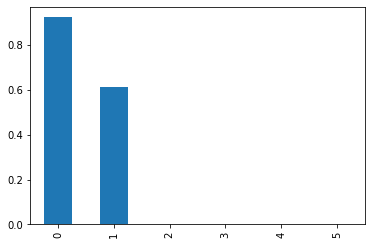

In [3]:
help(group_specialty)
specialty_count=df['medical_specialty'].value_counts()
#print(specialty_count)
(df.loc[df['readmitted']==1, 'discharge_disposition_id'].value_counts()/specialty_count).plot(kind='bar')

Help on function group_race in module myData:

group_race(x)
    0: Caucasian, 
    1: AfricanAmerican, 
    2: missing, 
    3: others



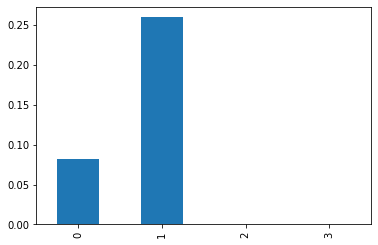

In [4]:
help(group_race)
race_count=df['race'].value_counts()
#print(race_count)
(df.loc[df['readmitted']==1, 'discharge_disposition_id'].value_counts()/race_count).plot(kind='bar')

Help on function group_age in module myData:

group_age(x)
    age 0-30: 0
    age 30-60: 1
    age 60-100: 2



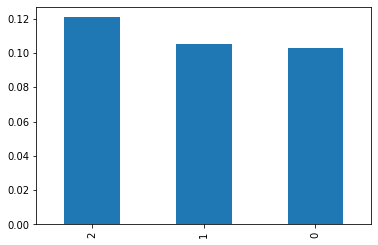

In [5]:
help(group_age)
age_count=df['age'].value_counts()
#print(age_count)

# age group 2 (60-90) has the highest readmission rate, next group 3 is (90-100), but all groups are closed
(df.loc[df['readmitted']==1, 'age'].value_counts()/age_count).plot(kind='bar')

Help on function group_discharge in module myData:

group_discharge(x)
    0: others, 
    1: discharged to home



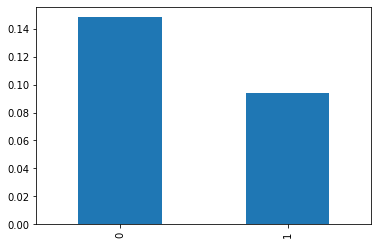

In [6]:
help(group_discharge)
discharge_count=df['discharge_disposition_id'].value_counts()
#print(discharge_count)

(df.loc[df['readmitted']==1, 'discharge_disposition_id'].value_counts()/discharge_count).plot(kind='bar')

In [7]:
help(group_readmitted)

Help on function group_readmitted in module myData:

group_readmitted(x)
    <30 days: 1
    Others: 0



In [8]:

#X = dummie
y = df['readmitted']
X = df.drop(columns=['readmitted'])
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.1, random_state=0)

X_train, X_train_lr, y_train, y_train_lr = ms.train_test_split(
    X_train, y_train, test_size=0.5)

In [9]:
y_train.value_counts().apply(lambda x: 100*x/y_train.shape[0])

0    88.344819
1    11.655181
Name: readmitted, dtype: float64

In [10]:
y_train_lr.value_counts().apply(lambda x: 100*x/y_train_lr.shape[0])

0    88.582266
1    11.417734
Name: readmitted, dtype: float64

In [11]:
y_test.value_counts().apply(lambda x: 100*x/y_test.shape[0])

0    88.349929
1    11.650071
Name: readmitted, dtype: float64

In [12]:
print(X_train.shape, X_train_lr.shape, X_test.shape)

(31634, 47) (31635, 47) (7030, 47)


In [13]:
# Random Forest,  and + Logistic Regression

n_estimator = 30
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator, random_state=42)
rf_enc = OneHotEncoder(categories='auto')
rf_lm = LogisticRegression(solver='saga', max_iter=1000, C=0.01, random_state=42)
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)
auc_rf_lm = auc(fpr_rf_lm, tpr_rf_lm)

print(auc_rf, auc_rf_lm)

0.667159018551709 0.6621916608231211


In [15]:
# Gradient Boosting, and + Logistic Regression

n_estimator = 700
grd = GradientBoostingClassifier(n_estimators=n_estimator,random_state=42)
grd_enc = OneHotEncoder(categories='auto')
grd_lm = LogisticRegression(solver='saga', max_iter=1000, C=0.001, random_state=42)
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)
auc_grd_lm = auc(fpr_grd_lm, tpr_grd_lm)

y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)
auc_grd = auc(fpr_grd, tpr_grd)
print(auc_grd, auc_grd_lm)

0.6644090627346142 0.6726727895621794


In [21]:
# Random Forest, and + Logistic Regression search

np.random.seed(10)
max_depth_grid = list(range(2,6))
n_estimator_grid = list(range(10, 50, 10))
C_grid = np.logspace(-3,3,7)
n = len(C_grid)
m = len(n_estimator_grid)
l = len(max_depth_grid)

auc_rf_grid = np.ndarray((l, m, n))
auc_rf_lm_grid = np.ndarray((l, m, n))

rf_grid = RandomForestClassifier(random_state=42)
rf_lm_grid = LogisticRegression(solver='saga', max_iter=1000, random_state=42)
rf_enc_grid = OneHotEncoder(categories='auto')


for i, max_depth in enumerate(max_depth_grid):
    for j, n_estimator in enumerate(n_estimator_grid):
        for k, c in enumerate(C_grid):
            rf_grid.set_params(n_estimators=n_estimator, max_depth=max_depth)
            rf_lm_grid.set_params(C=c)

            rf_grid.fit(X_train, y_train)
            rf_enc_grid.fit(rf_grid.apply(X_train))
            rf_lm_grid.fit(rf_enc_grid.transform(rf_grid.apply(X_train_lr)), y_train_lr)

            y_pred_rf_lm = rf_lm_grid.predict_proba(
                rf_enc_grid.transform(rf_grid.apply(X_test)))[:, 1]
            fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)
            auc_rf_lm_grid[i,j,k] = auc(fpr_rf_lm, tpr_rf_lm)

            y_pred_rf = rf_grid.predict_proba(X_test)[:, 1]
            fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
            auc_rf_grid[i,j,k] = auc(fpr_rf, tpr_rf)

auc_rf_grid_idx = np.unravel_index(auc_rf_grid.argmax(), auc_rf_grid.shape)
auc_rf_max = auc_rf_grid.max()
print('rf ', auc_rf_max, auc_rf_grid_idx)

auc_rf_lm_max = auc_rf_lm_grid.max()
auc_rf_lm_grid_idx = np.unravel_index(auc_rf_lm_grid.argmax(), auc_rf_lm_grid.shape)
print('rf + lm ', auc_rf_lm_max, auc_rf_lm_grid_idx)

if auc_rf_lm_max > auc_rf_max:
    depth_idx, estm_idx, c_idx = auc_rf_lm_grid_idx
else:
    depth_idx, estm_idx, c_idx = auc_rf_grid_idx

print(max_depth_grid[depth_idx], n_estimator_grid[estm_idx], C_grid[c_idx])

rf  0.6704465412402942 (3, 3, 0)
rf + lm  0.664100519598829 (1, 3, 1)
3 3 0
5 40 0.001


In [22]:
# Random Forest,  and + Logistic Regression
rf = RandomForestClassifier(max_depth=max_depth_grid[depth_idx],\
                            n_estimators=n_estimator_grid[estm_idx],\
                            random_state=42)
rf_enc = OneHotEncoder(categories='auto')
rf_lm = LogisticRegression(solver='saga', max_iter=1000, C=C_grid[c_idx], random_state=42)
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)
auc_rf_lm = auc(fpr_rf_lm, tpr_rf_lm)

print(auc_rf, auc_rf_lm)

0.6704465412402942 0.6624358217499419


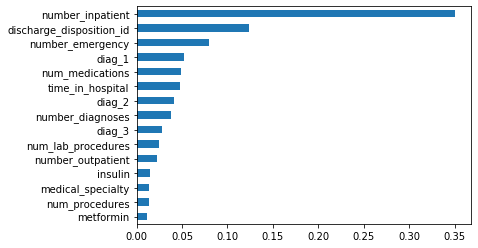

In [23]:
pd.Series(rf.feature_importances_, index=X_train.columns).sort_values()[-15:].plot(kind='barh')

In [ ]:
# Gradient Boosting, and + Logistic Regression search
C_grid = np.logspace(-3,3,7)
n_estimate_grid = list(range(100,1000,100))
m = len(C_grid)
n = len(n_estimate_grid)

auc_grd_grid = np.ndarray(shape=(m,n))
auc_grd_lm_grid = np.ndarray(shape=(m,n) 
grd_grid = GradientBoostingClassifier(random_state=42)
grd_lm_grid = LogisticRegression(solver='saga', max_iter=1000, random_state=42)
grd_enc_grid = OneHotEncoder(categories='auto')

for i, n_estimator in enumerate(n_estimate_grid):
    for j, C in enumerate(C_grid):
        grd_grid.set_params(n_estimators=n_estimator)
        grd_lm_grid.set_params(C=C)
        
        grd_grid.fit(X_train, y_train)
        grd_enc_grid.fit(grd_grid.apply(X_train)[:, :, 0])
        grd_lm_grid.fit(grd_enc_grid.transform(grd_grid.apply(X_train_lr)[:, :, 0]), y_train_lr)

        y_pred_grd_lm = grd_lm_grid.predict_proba(
            grd_enc_grid.transform(grd_grid.apply(X_test)[:, :, 0]))[:, 1]
        fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)
        auc_grd_lm_grid[i,j] = auc(fpr_grd_lm, tpr_grd_lm)

        y_pred_grd = grd_grid.predict_proba(X_test)[:, 1]
        fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)
        auc_grd_grid[i,j]= auc(fpr_grd, tpr_grd))

auc_grd_grid_idx = unravel_index(auc_grd_grid.argmax(), auc_grd_grid.shape)
aud_grd_max = auc_grd_grid.max()
print(aud_grd_max, auc_grd_grid_idx)

auc_grd_lm_grid_idx = np.unravel_index(auc_grd_lm_grid.argmax(), auc_grd_lm_grid.shape)
auc_grd_lm_max = auc_grd_lm_grid.max()
print(auc_grd_lm_max, auc_grd_lm_grid_idx)

if auc_grd_lm_max > auc_grd_max:
    estm_idx, c_idx = auc_rf_lm_grid_idx
else:
    estm_idx, c_idx = auc_rf_grid_idx

print(n_estimator_grid[estm_idx], C_grid[c_idx])

In [114]:
# max auc 0.672 at (C=0.001, n_estimator = 700) with grd + lm

# Gradient Boosting, and + Logistic Regression

n_estimator = 700
grd = GradientBoostingClassifier(n_estimators=n_estimator_grid[estm_idx],random_state=42)
grd_enc = OneHotEncoder(categories='auto')
grd_lm = LogisticRegression(solver='saga', max_iter=1000, C=C_grid[c_idx], random_state=42)
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)
auc_grd_lm = auc(fpr_grd_lm, tpr_grd_lm)

y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)
auc_grd = auc(fpr_grd, tpr_grd)
print(auc_grd, auc_grd_lm)

0.6628544535483837 0.6723435065086973


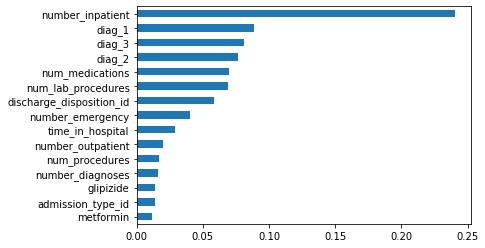

In [24]:
pd.Series(grd.feature_importances_, index=X_train.columns).sort_values()[-15:].plot(kind='barh')

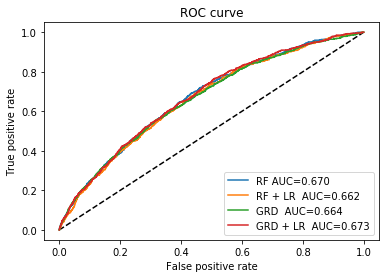

In [26]:

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF AUC={:.3f}'.format(auc_rf))
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR  AUC={:.3f}'.format(auc_rf_lm))
plt.plot(fpr_grd, tpr_grd, label='GRD  AUC={:.3f}'.format(auc_grd))
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GRD + LR  AUC={:.3f}'.format(auc_grd_lm))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
